# 0. 월간 데이콘 심리 성향 예측 AI 경진대회
* [월간 데이콘 심리 성향 예측 AI 경진대회](https://dacon.io/competitions/official/235647/overview/description)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
root_dir = "/gdrive/My Drive/Colab Notebooks/data/psychometrics"
train = pd.read_csv(f"{root_dir}/train.csv", index_col="index")
test = pd.read_csv(f"{root_dir}/test_x.csv", index_col="index")

# 1. EDA

In [4]:
train.shape, test.shape

((45532, 77), (11383, 76))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45532 entries, 0 to 45531
Data columns (total 77 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   QaA         45532 non-null  float64
 1   QaE         45532 non-null  int64  
 2   QbA         45532 non-null  float64
 3   QbE         45532 non-null  int64  
 4   QcA         45532 non-null  float64
 5   QcE         45532 non-null  int64  
 6   QdA         45532 non-null  float64
 7   QdE         45532 non-null  int64  
 8   QeA         45532 non-null  float64
 9   QeE         45532 non-null  int64  
 10  QfA         45532 non-null  float64
 11  QfE         45532 non-null  int64  
 12  QgA         45532 non-null  float64
 13  QgE         45532 non-null  int64  
 14  QhA         45532 non-null  float64
 15  QhE         45532 non-null  int64  
 16  QiA         45532 non-null  float64
 17  QiE         45532 non-null  int64  
 18  QjA         45532 non-null  float64
 19  QjE         45532 non-nul

In [6]:
set(train.columns) - set(test.columns)

{'voted'}

<Axes: xlabel='voted', ylabel='Count'>

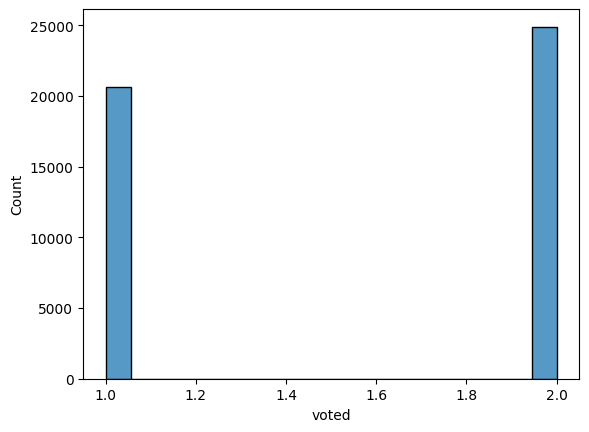

In [7]:
sns.histplot(train["voted"])

In [8]:
train.isnull().sum().sum()

0

In [9]:
test.isnull().sum().sum()

0

## 데이터 전처리


In [10]:
train["voted"] = train["voted"].map(lambda x:x-1)

In [11]:
train["age_group"] = train["age_group"].map(lambda x:int(x[:-1]))
test["age_group"] = test["age_group"].map(lambda x:int(x[:-1]))

In [12]:
obj_cols = train.select_dtypes(include="object").columns
obj_cols

Index(['gender', 'race', 'religion'], dtype='object')

In [13]:
from sklearn.preprocessing import LabelEncoder

for col in obj_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

# 2. 딥러닝

## 데이터셋

In [14]:
label_name = "voted"

In [15]:
X_train = train.drop(columns="voted")

In [16]:
y_train = train[label_name]

In [17]:
X_test = test

In [18]:
X_train.shape, y_train.shape, X_test.shape

((45532, 76), (45532,), (11383, 76))

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

## tensorflow

In [20]:
import tensorflow as tf
from tensorflow.keras import models, layers

In [21]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu',
                      input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(1, activation='sigmoid'))
#model.add(layers.Dense(1))

In [22]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ['AUC','accuracy'])

In [23]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [24]:
history = model.fit(X_train, y_train, epochs = 100, validation_split=0.2, callbacks = early_stop)

Epoch 1/100
1139/1139 [==============================] - 9s 5ms/step - loss: 0.6011 - auc: 0.7263 - accuracy: 0.6664 - val_loss: 0.5846 - val_auc: 0.7488 - val_accuracy: 0.6740
Epoch 2/100
1139/1139 [==============================] - 4s 3ms/step - loss: 0.5773 - auc: 0.7494 - accuracy: 0.6858 - val_loss: 0.5762 - val_auc: 0.7520 - val_accuracy: 0.6846
Epoch 3/100
1139/1139 [==============================] - 3s 2ms/step - loss: 0.5730 - auc: 0.7533 - accuracy: 0.6856 - val_loss: 0.5761 - val_auc: 0.7528 - val_accuracy: 0.6813
Epoch 4/100
1139/1139 [==============================] - 3s 3ms/step - loss: 0.5698 - auc: 0.7568 - accuracy: 0.6888 - val_loss: 0.5788 - val_auc: 0.7547 - val_accuracy: 0.6818
Epoch 5/100
1139/1139 [==============================] - 3s 2ms/step - loss: 0.5663 - auc: 0.7613 - accuracy: 0.6928 - val_loss: 0.5749 - val_auc: 0.7543 - val_accuracy: 0.6864
Epoch 6/100
1139/1139 [==============================] - 2s 2ms/step - loss: 0.5635 - auc: 0.7624 - accuracy: 0.693

In [25]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,auc,accuracy,val_loss,val_auc,val_accuracy
12,0.543532,0.782017,0.705285,0.581229,0.750146,0.687383
13,0.539565,0.786020,0.706712,0.578735,0.748168,0.684528
14,0.536160,0.788563,0.710062,0.592513,0.744125,0.681344
15,0.531988,0.792697,0.715086,0.598779,0.747024,0.682113
16,0.527338,0.796247,0.717392,0.590579,0.741397,0.674865


<Axes: >

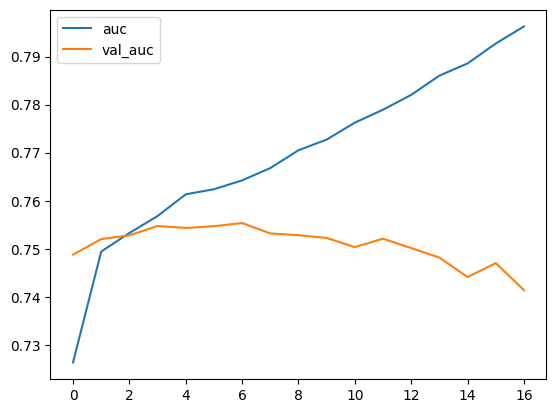

In [26]:
df_hist[["auc","val_auc"]].plot()

<Axes: >

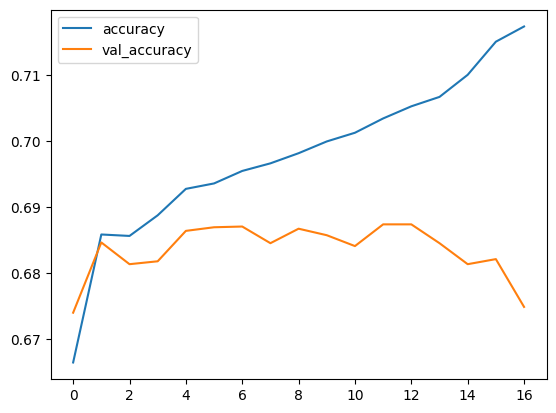

In [28]:
df_hist[["accuracy", "val_accuracy"]].plot()

## 모델 예측

In [29]:
y_pred = model.predict(X_test)
y_pred

356/356 [==============================] - 1s 1ms/step


array([[0.69471323],
       [0.995093  ],
       [0.19705221],
       ...,
       [0.06915849],
       [0.29161882],
       [0.93992484]], dtype=float32)

In [30]:
y_predict = (y_pred.flatten() > 0.5).astype(int)
y_predict

array([1, 1, 0, ..., 0, 0, 1])

## 모델 제출

In [31]:
submission = pd.read_csv(f"{root_dir}/sample_submission.csv", index_col="index")

In [32]:
submission["voted"] = y_predict

In [33]:
submission["voted"] = submission["voted"].map(lambda x:x+1)

In [37]:
score = float(df_hist["val_auc"][-1:])

In [38]:
file_name = f"submission_{score}.csv"

In [39]:
submission.to_csv(file_name)

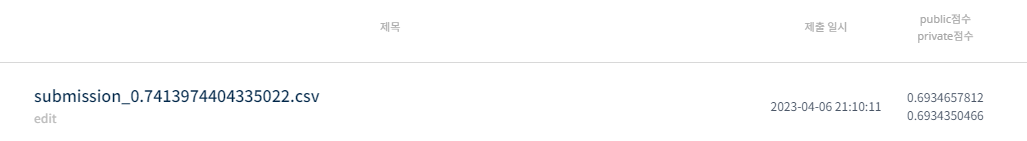